In [1]:
# !pip install pandas_datareader

In [27]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [28]:
# Load the data
company = 'FB' #Ticker Symbol of the company

start = dt.datetime(2012,1,1)
end = dt.datetime(2021,1,1)

data = web.DataReader(company, 'yahoo', start, end)

In [29]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [30]:
# Preparing the data
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append((scaled_data[x,0]))
    
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [46]:
# Building the model
model = Sequential()

model.add(LSTM(units=55, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [47]:
# Fitting the model
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
66/66 [==============================] - ETA: 0s - loss: 0.052 - 7s 49ms/step - loss: 0.0511
Epoch 2/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0036
Epoch 3/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0030
Epoch 4/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0026
Epoch 5/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0024
Epoch 6/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0026
Epoch 7/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0026
Epoch 8/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0026: 1s -
Epoch 9/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0025
Epoch 10/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0021
Epoch 11/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0023
Epoch 12/25
66/66 [==============================] - 3s 49ms/step - loss: 0.0021
Epoch 1

In [43]:
# Model's testing

# preparing the test data
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [44]:
# Making the predictions in TEST Data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


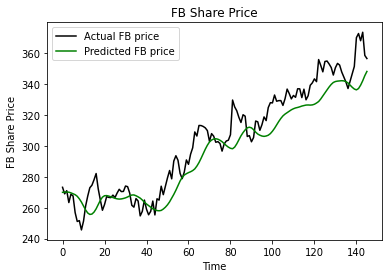

prediction: [[349.7484]]


In [45]:
# Plotting the prices

plt.plot(actual_prices, color="black", label=f"Actual {company} price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")